In [29]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l
import numpy as np
import matplotlib.pyplot as plt

In [8]:
class Data(d2l.DataModule):
    def __init__(self, num_train, num_val, num_inputs, batch_size):
        self.save_hyperparameters()
        n = num_train + num_val
        self.X = torch.randn(n, num_inputs)
        noise = torch.randn(n, 1) * 0.01
        w, b = torch.ones((num_inputs, 1)) * 0.01, 0.05
        self.y = torch.matmul(self.X, w) + b + noise

    def get_dataloader(self, train):
        i = slice(0, self.num_train) if train else slice(self.num_train, None)
        return self.get_tensorloader([self.X, self.y], train, i)

1. **Experiment with the value of $\lambda$ in the estimation problem in this section. Plot training and validation accuracy as a function of $\lambda$. What do you observe?**

In [35]:
class WeightDecay(d2l.LinearRegression):
    def __init__(self, wd, lr, plot_flag=True):
        super().__init__(lr)
        self.save_hyperparameters()
        self.wd = wd

    def configure_optimizers(self):
        return torch.optim.SGD([
            {'params': self.net.weight, 'weight_decay': self.wd},
            {'params': self.net.bias}], lr=self.lr)
    
    def training_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        if self.plot_flag:
            self.plot('loss', l, train=True)
        return l

    def validation_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        if self.plot_flag:
            self.plot('loss', l, train=False)
        return l

@d2l.add_to_class(d2l.Trainer) #@save
def return_train_loss(self):
    loss = 0
    for batch in self.train_dataloader:
        loss += self.model.training_step(self.prepare_batch(batch)).item()
    loss /= len(self.train_dataloader)
    return loss

@d2l.add_to_class(d2l.Trainer) #@save
def return_val_loss(self):
    loss = 0
    for batch in self.val_dataloader:
        loss += self.model.validation_step(self.prepare_batch(batch)).item()
    loss /= len(self.val_dataloader)
    return loss

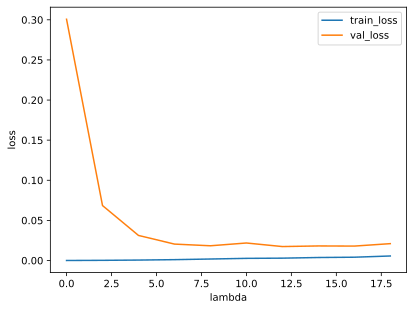

In [40]:
data = Data(num_train=20, num_val=100, num_inputs=200, batch_size=5)
lambda_list = np.arange(0, 20, 2)
train_loss = []
val_loss = []

for lamb in lambda_list:
    trainer = d2l.Trainer(max_epochs=10)
    model = WeightDecay(wd=lamb, lr=0.01, plot_flag=False)
    trainer.fit(model, data)
    train_loss.append(trainer.return_train_loss())
    val_loss.append(trainer.return_val_loss())

plt.plot(lambda_list, train_loss, label="train_loss")
plt.plot(lambda_list, val_loss, label="val_loss")
plt.xlabel("lambda")
plt.ylabel("loss")
plt.legend()
plt.show()

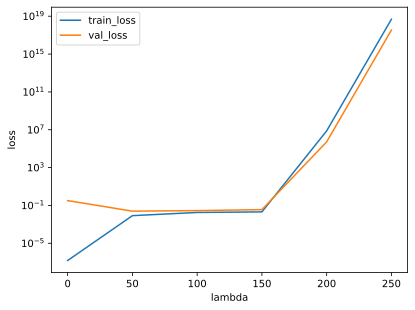

In [44]:
data = Data(num_train=20, num_val=100, num_inputs=200, batch_size=5)
lambda_list = np.arange(0, 300, 50)
train_loss = []
val_loss = []

for lamb in lambda_list:
    trainer = d2l.Trainer(max_epochs=10)
    model = WeightDecay(wd=lamb, lr=0.01, plot_flag=False)
    trainer.fit(model, data)
    train_loss.append(trainer.return_train_loss())
    val_loss.append(trainer.return_val_loss())

plt.plot(lambda_list, train_loss, label="train_loss")
plt.plot(lambda_list, val_loss, label="val_loss")
plt.xlabel("lambda")
plt.ylabel("loss")
plt.yscale('log')
plt.legend()
plt.show()

We can see that, by appropriately increasing the value of $\lambda$, the validation loss reduced, indicating that the overfitting problem has been effectively alleviated. However, when $\lambda$ is too large, the loss of both training and validation will be very high, indicating that the model cannot effectively fit the data.

2. **Use a validation set to find the optimal value of $\lambda$. Is it really the optimal value? Does this matter?**

While the chosen $\lambda$ might work well on the specific validation set, it is probably not the optimal value for unseen test data. So it is not really the optimal value. However, it doesn't matter if the $lambda$ is optimal. We can trust that the $\lambda$ can produce good result if the validation set can represent the distribution and feature of the whole dataset. 

3. **What would the update equations look like if instead of $|\mathbf{w}|^2$ we used $\sum_i |w_i|$ as our penalty of choice ($\ell_1$ regularization)?**

$$\begin{aligned}
\mathbf{w} & \leftarrow \mathbf{w} - \eta \lambda sign\left( \mathbf{w}\right) - \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} \mathbf{x}^{(i)} \left(\mathbf{w}^\top \mathbf{x}^{(i)} + b - y^{(i)}\right).
\end{aligned}$$

4. **We know that $|\mathbf{w}|^2 = \mathbf{w}^\top \mathbf{w}$. Can you find a similar equation for matrices (see the Frobenius norm in Section 2.3.11)?**

According to the Frobenius norm:

$$\|\mathbf{X}\|_\textrm{F} = \sqrt{\sum_{i=1}^m \sum_{j=1}^n x_{ij}^2}$$

Then we can get a similar equation:

$$\|\mathbf{X}\|^2_\textrm{F} = tr(\mathbf{X}^T\mathbf{X})$$

5. **Review the relationship between training error and generalization error. In addition to weight decay, increased training, and the use of a model of suitable complexity, what other ways might help us deal with overfitting?**

(1) We can observe the changing trends of the training error and validation error curves during training. If the validation error increases, it means overfitting and we should stop training.

(2) we can use dropout to randomly deactivates a portion of the neurons during each training iteration, forcing the network to learn robust representations.

(3) We can select relevant features and reduce irrelevant ones to help the model focus on the most important patterns in the data.

6. **In Bayesian statistics we use the product of prior and likelihood to arrive at a posterior via $P(w \mid x) \propto P(x \mid w) P(w)$. How can you identify $P(w)$ with regularization?**

The prior distribution P(w) can act as a form of regularization. For L2 regularization, the prior distribution P(w) is chosen to be a Gaussian distribution with mean 0 and a fixed variance (scale parameter). This encourages the parameter values to be closer to zero, effectively penalizing large parameter values.

We prove it using linear regression:

Consider a linear regression model:

$$\mathbf{y}=\mathbf{X}\mathbf{w}+\mathbf{\epsilon}$$
$\mathbf{\epsilon}$ is the error vector, assumed to follow a Gaussian distribution $N(0, \sigma^2)$

The likelihood function is:

$$P(y|X,w,\sigma^2)=\frac1{(2\pi\sigma^2)^{n/2}}\exp\left(-\frac1{2\sigma^2}\|y-Xw\|^2\right)$$

Suppose w follows Gaussian distribution $N(0, \tau^2)$. The dimension of w is p. The prior distribution is:
$$P(w)=\frac1{(2\pi\tau^2)^{p/2}}\exp\left(-\frac1{2\tau^2}\|w\|^2\right)$$

The form of MAP estimate is:
$$\begin{aligned}
\hat{\theta}_{\mathbf{MAP}}& =\arg\max_\theta P(\theta|y) \\
&=\arg\max_\theta\frac{P(y|\theta)P(\theta)}{P(y)} \\
&=\arg\max_\theta P(y|\theta)P(\theta) \\
&=\arg\max_\theta\log(P(y|\theta)P(\theta)) \\
&=\arg\max_\theta\log P(y|\theta)+\log P(\theta)
\end{aligned}$$

Combine the bove equations:

$$ \begin{aligned} 
\hat{w}_{\mathbf{MAP}} & = \arg \max_w \log P(y|X,w,\sigma^2) + \log P(w) \\
&= \arg\max_w -\frac1{2\sigma^2}\|y-Xw\|^2 -\frac1{2\tau^2}\|w\|^2 \\
&= \arg\min_w \|y-Xw\|^2 + \frac{\sigma^2}{\tau^2} \|w\|^2 \\
&= \arg\min_w \|y-Xw\|^2 + \lambda \|w\|^2
\end{aligned}$$

The L1 regularizer introduces a Laplace distribution as the prior for the parameters, which leads to a sparsity-inducing effect. This can drive some parameter values to exactly zero, effectively performing feature selection.